_Author:  Stephen Carr_

In [3]:
using DMRJtensor
include("su2_tools.jl");

In [4]:
# setup spin 1 model
spinmag = 1.0;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag);

In [30]:
# XY model

tar_phase = 3 # 1: AKLT, 2: critical point, 3: Dimerized
θ = 0;
if tar_phase == 1
    θ = atan(1.0/3.0)
elseif tar_phase == 2
    θ = -π/4.0
elseif tar_phase == 3
    θ = -π/2.0
end

J_arr = [cos(θ), sin(θ)];

max_m = 81
if (tar_phase == 2)
    max_m = 256
end


L_list = 4:4:32
var_arr = []
target_arr = []

for L = L_list  # number of sites
    
    H_onesite = H_SU2(spinmag, J_arr) # make the onsite term
    H_mpo = makeMPO(H_onesite,size(Id,1),L); # make the MPO!
    psi = makePsi0(spinmag,L);
    
    # DMRG sweeps, with refinement 
    nsweeps_m40 = 20
    nsweeps_m128 = 40

    for i in 1:nsweeps_m40
        dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-4)
    end
    println("coarse run completed")
    for i in 1:nsweeps_m128
        dmrg(psi, H_mpo, maxm = max_m, cutoff = 1E-10)
    end
    println("intermediate run completed")
    #for i in 1:nsweeps_m80
    #    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
    #end
    #println("fine run completed")
    variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
    println("L=", L)
    println("var=",abs(variance))
    push!(var_arr,abs(variance))
    
    center = Int64(L/2)

    Id_onesite_dimer = [Id O O O 
                         O O O O
                         O O O O
                         O O O Id]
    dimer_op_L =        [Id O O O 
                         O O O O
                         O O O O
                         O Sx Sy Id]
    dimer_op_R =        [Id O O O 
                         Sx O O O
                         Sy O O O
                         O O O Id]

    # + term in dimer formula, at site [center+1]
    dimer_p = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
    dimer_p[center] = dimer_op_L
    dimer_p[center+1] = dimer_op_R
    dimer_m = Array{ComplexF64,2}[Id_onesite_dimer for n =  1:L]
    dimer_m[center-1] = dimer_op_L
    dimer_m[center] = dimer_op_R    

    dimer_p_mpo = makeMPO(dimer_p,size(Id,1),L);
    dimer_m_mpo = makeMPO(dimer_m,size(Id,1),L);

    Δ_p = expect(psi,dimer_p_mpo)
    Δ_m = expect(psi,dimer_m_mpo)
    Δ = (-1)^(center-1)*(Δ_p - Δ_m)
    println("Δ = ",Δ)
    push!(target_arr,Δ)
    
end

coarse run completed
intermediate run completed
L=4
var=9.663614583341837e-13
Δ = -0.9701424651792542 - 6.245004513516506e-17im
coarse run completed
intermediate run completed
L=8
var=8.563847586647013e-8
Δ = -0.7777958156425714 - 1.734723475976807e-17im
coarse run completed
intermediate run completed
L=12
var=1.4489598697764457e-5
Δ = -0.7052662435621455 - 2.654126918244515e-16im
coarse run completed
intermediate run completed
L=16
var=4.884565328211466e-5
Δ = -0.6654388623818119 + 3.0531133177191805e-16im
coarse run completed
intermediate run completed
L=20
var=0.00010990148166456493
Δ = -0.6402899861595442 + 1.8388068845354155e-16im
coarse run completed
intermediate run completed
L=24
var=0.0001899014532682486
Δ = -0.6230692384275184 + 5.065392549852277e-16im
coarse run completed
intermediate run completed
L=28
var=0.00029287553297763225
Δ = -0.6106697047514036 - 3.3306690738754696e-16im
coarse run completed
intermediate run completed
L=32
var=0.00041385183794773184
Δ = -0.601450445

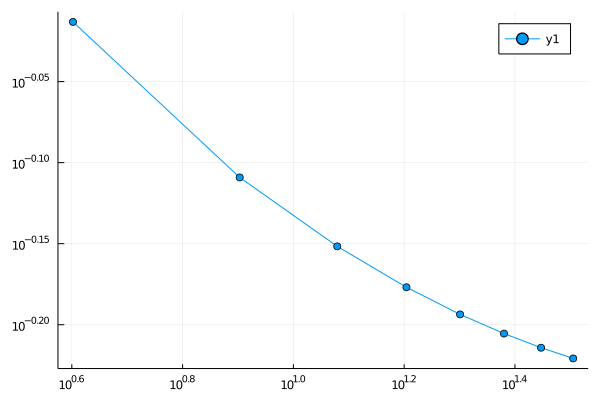

In [31]:
# plot <var> vs L, log-log
using Plots

plot(L_list,broadcast(abs,target_arr), marker=:circle,xaxis=:log, yaxis=:log)
#plot!(L_list,L_list.^(-1),xaxis=:log,yaxis=:log)    


#plot(L_list,broadcast(abs,Sz_arr), marker=:circle, xaxis=:log, yaxis=:log,label="Sz")
#plot!(L_list,L_list.^(-1),xaxis=:log,yaxis=:log)

#plot(broadcast(abs,Sx_arr),marker=:circle,xaxis=:log,yaxis=:log)
#plot!(L_list,L_list.^(-1/4),xaxis=:log,yaxis=:log)

In [32]:
using CSV, DataFrames

df = DataFrame(L=L_list,Delta=broadcast(abs,target_arr))
CSV.write("dimerized.csv", df)


"dimerized.csv"

In [7]:
L = 4
H_onesite = H_SU2(spinmag, J_arr) # make the onsite term
H_mpo = makeMPO(H_onesite,size(Id,1),L); # make the MPO!

println(H_mpo[3])
mpo_dims = H_mpo[3].size
mpo_mat = H_mpo[3].T


println(mpo_dims) # has indices [a1,s1,s2,a2]
for a1 = 1:mpo_dims[1] # major row
    for s1= 1:mpo_dims[2] # minor row
        for a2 = 1:mpo_dims[4] # major col
            for s2=1:mpo_dims[3] # minor col
                idx_h = a1 + (s1-1)*mpo_dims[1] + (s2-1)*mpo_dims[1]*mpo_dims[2] + (a2-1)*mpo_dims[1]*mpo_dims[2]*mpo_dims[3]

                print(round(abs(mpo_mat[idx_h]),digits=1))
                print(" ")
            end
            print("| ")
        end
        print("\n")
    end
    for row_sep = 1:(mpo_dims[3]*mpo_dims[4])
        print("----")
    end
    print("\n")
end

println(Sx)

printing regular tensor of type: tens{Complex{Float64}}
size = (5, 2, 2, 5)
T = Complex{Float64}[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im]...

(5, 2, 2, 5)
1.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
0.0 1.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
----------------------------------------
0.0 0.5 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
0.5 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
----------------------------------------
0.0 0.5 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
0.5 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
----------------------------------------
0.5 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
0.0 0.5 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 0.0 0.0 | 
----------------------------------------
0.0 0.0 | 0.0 0.5 | 0.0 0.5 | 0.5 0.0 | 1.0 0.0 | 
0.0 0.0 | 0.5 0.0 | 0.5 0.0 | 0.0 0.5 | 0.0 1.0 | 
----------------------------------------
[0.0 0.5; 0.5 0.0]


In [96]:
# plot <var> vs L, log-log
using Plots

df_dimer = DataFrame
df_aklt = DataFrame
df_critical = DataFrame


df_dimer = CSV.read("dimerized.csv",df_dimer);
df_aklt = CSV.read("aklt.csv",df_aklt);
df_critical = CSV.read("critical_point.csv",df_critical);

plot(df_aklt.L,df_aklt.Delta*1e8, marker=:circle,xaxis=:log, yaxis=:log,label="θ = 0.321751")
plot!(df_critical.L,df_critical.Delta, marker=:circle,xaxis=:log, yaxis=:log,label="θ = -π/4")
plot!(df_dimer.L,df_dimer.Delta, marker=:circle,xaxis=:log, yaxis=:log,label="θ = -π/2")

plot!(xlims=(3.5,100),ylims=(0.2,1.5))
plot!(xlabel="L",ylabel="Δ(L/2)")

savefig("SU2_spin1_DMRGJulia_test.png")

coarse run completed
intermediate run completed
L=16
var=1.989555783845765e-13


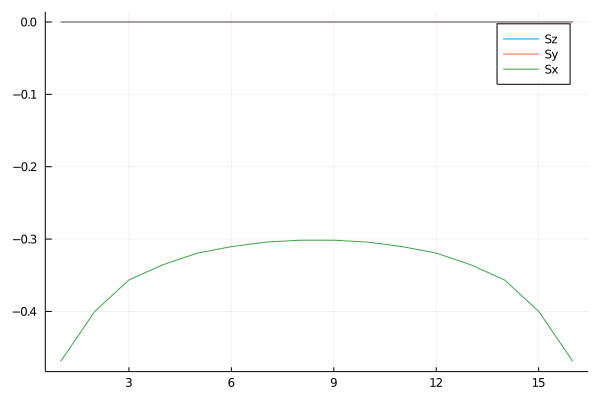

In [392]:
# Check field dependence of <S_i>

# XY model
J = -1;
H_n = [Id O O O
       J*Sx O O O
       J*Sy O O O
       O  Sx Sy Id];
# edge magnetic field
h = 1.0;
H_left = [Id O O O
          J*Sx O O O
          J*Sy O O O
          h*Sx Sx Sy Id]

H_right = [Id O O O
          J*Sx O O O
          J*Sy O O O
          h*Sx Sx Sy Id];


L = 16
Sx_arr = []
Sy_arr = []
Sz_arr = []

H_op = Array{ComplexF64,2}[H_n for n =  1:L]
H_op[1] = H_left
H_op[L] = H_right
H_mpo = makeMPO(H_op,size(Id,1),L); # make the MPO!
psi = makePsi0(spinmag,L);

# DMRG sweeps, with refinement 
nsweeps_m40 = 10
nsweeps_m128 = 80

for i in 1:nsweeps_m40
    dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-4)
end
println("coarse run completed")
for i in 1:nsweeps_m128
    dmrg(psi, H_mpo, maxm = 128, cutoff = 1E-14)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("L=", L)
println("var=",abs(variance))
    
for tar_site = 1:L
    Id_onesite = Id

    # + term in dimer formula, at site [center+1]
    Sz_op = Sz;
    Sx_op = Sx;
    Sy_op = Sy;
    
    Sz_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sz_h[tar_site] = Sz_op
    Sx_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sx_h[tar_site] = Sx_op
    Sy_h = Array{ComplexF64,2}[Id_onesite for n =  1:L]
    Sy_h[tar_site] = Sy_op
    
    Sz_mpo = makeMPO(Sz_h,size(Id,1),L); # make the MPO!
    Sz_val = expect(psi,Sz_mpo)
    push!(Sz_arr,real(Sz_val))
    
    Sx_mpo = makeMPO(Sx_h,size(Id,1),L); # make the MPO!
    Sx_val = expect(psi,Sx_mpo)
    push!(Sx_arr,real(Sx_val))
    
    Sy_mpo = makeMPO(Sy_h,size(Id,1),L); # make the MPO!
    Sy_val = expect(psi,Sy_mpo)
    push!(Sy_arr,real(Sy_val))
    
end

plot(Sz_arr,label="Sz")
plot!(Sy_arr,label="Sy")
plot!(Sx_arr,label="Sx")

Any[-0.4690629822429049, -0.39986462959296126, -0.35641848737917836, -0.3353454244532331, -0.31939249423487365, -0.3104027639511995, -0.30417800827428915, -0.3015661681936507, -0.3015661681869334, -0.30417800826911817, -0.31040276395551936, -0.31939249423623683, -0.33534542445310184, -0.35641848738227877, -0.39986462961262187, -0.4690629822662281]


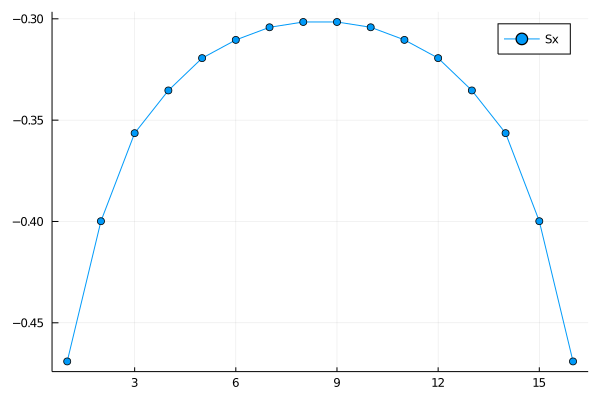

In [393]:
println(Sx_arr)
plot(Sx_arr,label="Sx",marker=:circle)
#plot!(Sy_arr,label="Sy")


In [288]:
tar_site = 1;
println(H_mpo[tar_site])
mpo_dims = H_mpo[tar_site].size
mpo_mat = H_mpo[tar_site].T


println(mpo_dims) # has indices [a1,s1,s2,a2]
for a1 = 1:mpo_dims[1] # major row
    for s1= 1:mpo_dims[2] # minor row
        for a2 = 1:mpo_dims[4] # major col
            for s2 = 1:mpo_dims[3] # minor col
                idx_h = a1 + (s1-1)*mpo_dims[1] + (s2-1)*mpo_dims[1]*mpo_dims[2] + (a2-1)*mpo_dims[1]*mpo_dims[2]*mpo_dims[3]

                print(round(abs(mpo_mat[idx_h]),digits=1))
                print(" ")
            end
            print("| ")
        end
        print("\n")
    end
    for row_sep = 1:(mpo_dims[3]*mpo_dims[4])
        print("----")
    end
    print("\n")
end

printing regular tensor of type: tens{Complex{Float64}}
size = (1, 2, 2, 4)
T = Complex{Float64}[5.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -5.0 + 0.0im]...

(1, 2, 2, 4)
5.0 0.0 | 0.0 0.5 | 0.0 0.5 | 1.0 0.0 | 
0.0 5.0 | 0.5 0.0 | 0.5 0.0 | 0.0 1.0 | 
--------------------------------


In [285]:
#println(Sx)
println(H_op[1])
n = convert(Int64,sqrt(length(H_op[1])))
for r = 1:n
    for c = 1:n
        idx = (c-1)*n + r
        print(abs(H_op[1][idx]), " ")
    end
    print("\n")
end

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0 + 0.0im -0.5 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.5 + 0.0im -0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0 + 0.0im -0.0 + 0.5im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.5im -0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 5.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.5 + 0.0im 0.0 - 0.0im 0.0 - 0.5im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -5.0 + 0.0im 0.5 + 0.0im 0.0 + 0.0im -0.0 + 0.5im 0.0 - 0.0im 0.0 + 0.0im 1.0 + 0.0im]
1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 
0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 
0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
